In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import helpfunction as helper
from __future__ import division

import collections
import NuCC_function as NuCC

Welcome to JupyROOT 6.10/08


In [8]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [3]:
# Load input files

inputdir = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/'
outputdir = inputdir+'NumuCC_cut_analysis_V_10y/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

filename_overlay = 'NuCCana_overlay_V.root'
filename_data = 'NuCCana_data_V.root'
filename_ext = 'NuCCana_ext_V.root'
filename_dirt = 'NuCCana_dirt_V.root'
    
tree_name = 'numuCCAna'

In [4]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)

pot_data =      8.039e+18 # tor860_wcut
data_trigger = 1942081.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  22622263.0  #2120135 #5685315 # EXT
'''
pot_data =     1.25795274297e+18# tor860_wcut
data_trigger = 1359818.0*0.4 # E1DCNT
ext_trigger =  1359818.0  #2120135 #5685315 # EXT
pot_overlay = 1.25795274297e+18/0.5
pot_dirt = 1.25795274297e18/0.04
'''
print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]*1.3
scale[overlay] = scale[overlay]*1.3
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	966222
Data: Number of Entries:	34835
Ext: Number of Entries:		263935
Dirt: Number of Entries:	96465

POT: 
Data:		8.039e+18
Ext:		0
Overlay:	1.21058333557e+21
Dirt:		2.9866803255e+20

Scalefactors: 
Data:		1.0
Ext:		0.0858482195172
Overlay:	0.00863278032409
Dirt:		0.0349910230123


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [5]:
# Define signals

fidVol = '(Nu_Vx>(-1.55+10) && Nu_Vx<(254.8-10)) && (Nu_Vy>(-115.53+10) && Nu_Vy<(117.47-10)) &&(Nu_Vz>(-0.1+10) && Nu_Vz<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG==13 && MCle_purity>0.5' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG!=13 && MCle_purity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_purity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [6]:
# Load the global variables for access of functions

NuCC.loadGlobal(data,ext,dirt,overlay,scale,tot_num_fidVol,overlay_signals,sample, name, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


First mean: 0.00960983847483
First std: 0.518045227333
First mean: 0.00535282880081
First std: 0.530524637696
First mean: -0.330454769701
First std: 0.626926883485
 FCN=168309 FROM MIGRAD    STATUS=CONVERGED     130 CALLS         131 TOTAL
                     EDM=1.00185e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.26490e+04   3.62131e+01   2.28106e-02   1.87348e-06
   2  Mean         9.60984e-03   8.07424e-04   6.66554e-07   4.62746e-02
   3  Sigma        5.18045e-01   1.24426e-03  -5.04579e-08   8.17422e-02
 FCN=174745 FROM MIGRAD    STATUS=CONVERGED     131 CALLS         132 TOTAL
                     EDM=1.13502e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DER

Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_pos_Vx.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_pos_Vx.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_pos_Vy.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_pos_Vy.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_pos_Vz.png has been created
Info in 

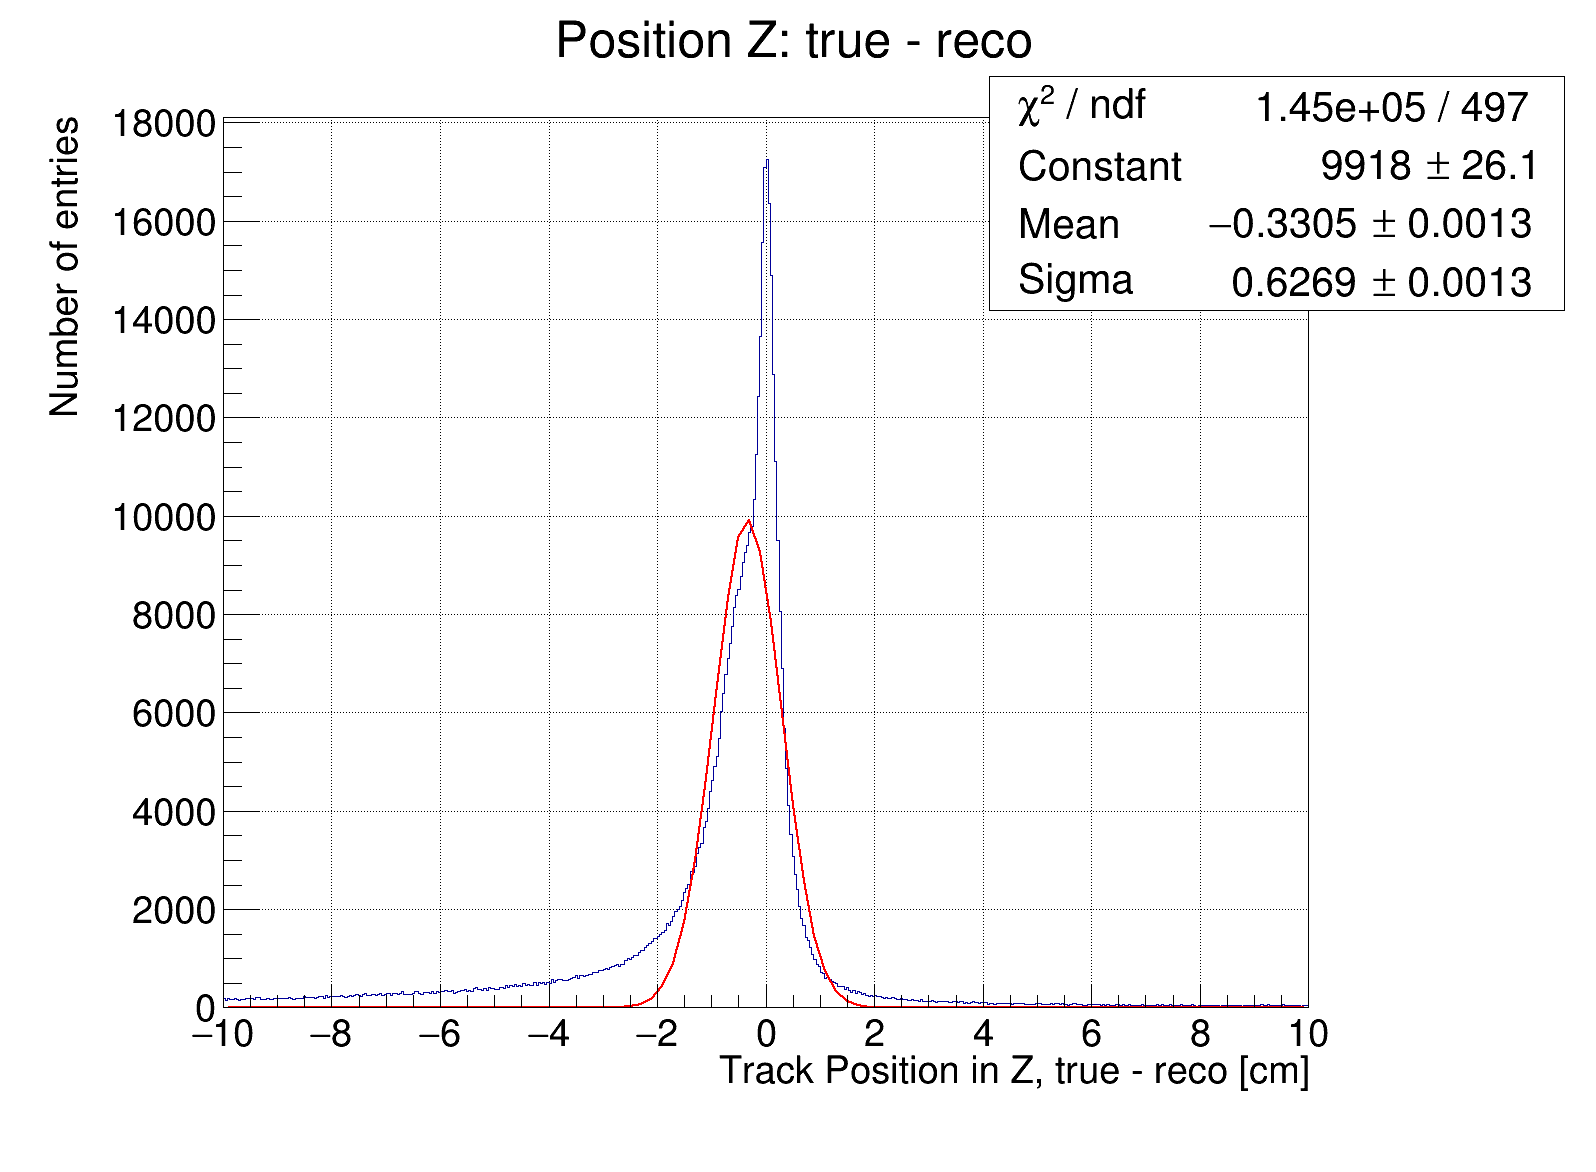

In [17]:
title = 'Position X: true - reco'
name = 'Vx'
xstart = -10
xend = 10
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_VxSce-TrackStart_x>>h_pos','MCle_Vx!=-999')
h_pos.SetXTitle("Track Position in X, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

title = 'Position Y: true - reco'
name = 'Vy'
xstart = -10
xend = 10
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_VySce-TrackStart_y>>h_pos','MCle_Vy!=-999')
h_pos.SetXTitle("Track Position in Y, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

title = 'Position Z: true - reco'
name = 'Vz'
xstart = -10
xend = 10
xbin = 500
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(1)
h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
overlay.Draw('MCle_VzSce-TrackStart_z>>h_pos','MCle_Vz!=-999')
h_pos.SetXTitle("Track Position in Z, true - reco [cm]")
h_pos.SetYTitle("Number of entries")
f1 = ROOT.TF1("f1","gaus",xstart,xend)
h_pos.Fit("f1","R");
print 'First mean:', f1.GetParameter(1)
print 'First std:', f1.GetParameter(2)
h_pos.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_pos_"+name+".png")
c1.SaveAs(outputdir_root + "h_pos_"+name+".root")

In [8]:
# Print initial efficiency and purity

NuCC.printEff('muon')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		100.00%
Purity:			33.35%
Purity*Efficiency	33.35

Amount of    data:	107.74%
Amount of     ext:	37.00%
Amount of overlay:	57.91%
Amount of    dirt:	5.09%

Signal definition=  numu_lowpur: 2.10%	(3.63%)
Signal definition=   numu_other: 0.48%	(0.83%)
Signal definition=    numu_nomu: 4.34%	(7.50%)
Signal definition=      numu_ov: 10.79%	(18.64%)
Signal definition=  numu_signal: 33.35%	(57.58%)
Signal definition=      numu_nc: 6.83%	(11.80%)


In [ ]:
track_start_border_x = '(TrackStart_x <(-1.55+1) || TrackStart_x > (254.8-1))'
track_end_border_x = '(TrackEnd_x <(-1.55+1) || TrackEnd_x > (254.8-1))'
track_start_border_y = '(TrackStart_y <(-115.53+1) || TrackStart_y > (117.47-1))'
track_end_border_y = '(TrackEnd_y <(-115.53+1) || TrackEnd_y > (117.47-1))'
track_start_border_z = '(TrackStart_z <(0.1+1) || TrackStart_z > (1036.9-1))'
track_end_border_z = '(TrackEnd_z <(0.1+1) || TrackEnd_z > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)



In [24]:
# Generate stacked plots without any cuts

#NuCC.make_stacked_histo_plot('fidVol','TimFla','Flash_time [us]',2,6,20,'FlashTime')

#NuCC.make_stacked_histo_plot_flashcorr('fidVol','TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr')
#NuCC.make_stacked_histo_plot_crtcorr('fidVol','crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr')

#NuCC.make_stacked_histo_plot('fidVol && muon','TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom')
#NuCC.make_stacked_histo_plot('fidVol && muon','TrackLength','Track length [cm]',0,500,20,'tracklength')
#NuCC.make_stacked_histo_plot('fidVol && TrackTheta!=-9 && muon','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta')
#NuCC.make_stacked_histo_plot('fidVol && TrackTheta!=-9 && muon','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi')
#NuCC.make_stacked_histo_plot('fidVol && muon','NuScore','Total NuScore of event',0,1,20,'NuScore')
#NuCC.make_stacked_histo_plot('fidVol && muon','NuTracks','Number of tracks',0,8,8,'num_tracks')

#NuCC.make_stacked_histo_plot('fidVol && muon','Nu_Vx','Reco. Nu vertex X position [cm]',0,250,50,'NuVx')
#NuCC.make_stacked_histo_plot('fidVol && muon','Nu_Vy','Reconstructed neutrino vertex Y position [cm]',-110,115,50,'NuVy')
#NuCC.make_stacked_histo_plot('fidVol && muon','Nu_Vz','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz')


In [9]:
#NuCC.make_stacked_histo_plot_crtt0corr('fidVol','crtt0_time','associated CRT hit time [us]',2.3,5.9,20,'CRTT0_corr_all')
#NuCC.make_stacked_histo_plot_crtt0corr('fidVol && muon','crtt0_time','associated CRT hit time [us]',-2000,2000,20,'CRTT0_corr_big')

In [10]:
# Define CRT cut

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<1 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<1 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<1 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<1 || crtt0_time==-1)")

track_start_border_x = '(TrackStart_x <(-1.55+5) || TrackStart_x > (254.8-5))'
track_end_border_x = '(TrackEnd_x <(-1.55+5) || TrackEnd_x > (254.8-5))'
track_start_border_y = '(TrackStart_y <(-115.53+5) || TrackStart_y > (117.47-5))'
track_end_border_y = '(TrackEnd_y <(-115.53+5) || TrackEnd_y > (117.47-5))'
track_start_border_z = '(TrackStart_z <(0.1+5) || TrackStart_z > (1036.9-5))'
track_end_border_z = '(TrackEnd_z <(0.1+5) || TrackEnd_z > (1039.9-5))'

track_end_uncontained = track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)


True

In [11]:
#NuCC.make_stacked_histo_plot_crtt0corr('fidVol && (crt_cut || NuTracks != 1)','crtt0_time','associated CRT hit time [us]',-2000,2000,20,'CRTT0_corr_test')

In [12]:
# Print efficiency with crt cut

#NuCC.printEff('crt_cut && muon')

#NuCC.printEff('crt_cut_test && muon')

In [13]:
#NuCC.printEff('crt_cut')

In [14]:
# generate stacked plots with crt cut
cut = 'fidVol && muon && crt_cut'
name = '_crt'

#NuCC.make_stacked_histo_plot_flashcorr(cut,'TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr'+name)
#NuCC.make_stacked_histo_plot_crtcorr(cut,'crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr'+name)

#NuCC.make_stacked_histo_plot(cut,'TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom'+name)
#NuCC.make_stacked_histo_plot(cut,'TrackLength','Track length [cm]',0,500,20,'tracklength'+name)
#NuCC.make_stacked_histo_plot(cut + ' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
#NuCC.make_stacked_histo_plot(cut + ' && TrackTheta!=-9','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi'+name)
#NuCC.make_stacked_histo_plot(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)
#NuCC.make_stacked_histo_plot(cut,'NuTracks','Number of tracks',0,8,8,'num_track'+name)

#NuCC.make_stacked_histo_plot(cut,'Nu_Vx','Reco. Nu vertex X position [cm]',0,250,50,'NuVx'+name)
#NuCC.make_stacked_histo_plot(cut,'Nu_Vy','Reconstructed neutrino vertex Y position [cm]',-110,115,50,'NuVy'+name)
#NuCC.make_stacked_histo_plot(cut,'Nu_Vz','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz'+name)

In [15]:
# Define track length cut

data.SetAlias("tracklength_cut","TrackLength>29")
ext.SetAlias("tracklength_cut","TrackLength>29")
overlay.SetAlias("tracklength_cut","TrackLength>29")
dirt.SetAlias("tracklength_cut","TrackLength>29")

True

In [9]:
# Efficiency and purity with crt and tracklength cut

NuCC.printEff('fidVol && muon && TrackLength>20 && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)')

Rejection on each sample:
Keep of    data:	44.10%	 reject:	55.90%
Keep of     ext:	23.49%	 reject:	76.51%
Keep of overlay:	58.73%	 reject:	41.27%
Keep of    dirt:	29.90%	 reject:	70.10%

Efficiency:		80.68%
Purity:			60.84%
Purity*Efficiency	49.09

Amount of    data:	107.43%
Amount of     ext:	19.65%
Amount of overlay:	76.91%
Amount of    dirt:	3.44%

Signal definition=  numu_lowpur: 0.74%	(0.96%)
Signal definition=   numu_other: 0.60%	(0.79%)
Signal definition=    numu_nomu: 3.75%	(4.88%)
Signal definition=      numu_ov: 7.44%	(9.68%)
Signal definition=  numu_signal: 60.84%	(79.11%)
Signal definition=      numu_nc: 3.53%	(4.59%)


In [10]:
NuCC.printNumber('fidVol && muon && TrackLength>20 && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)')

Rejection on each sample:
Number of true signal:		1121.26
Number of total events:		1843.06
Number of data events:		1980.00
Number of bk events:		721.80


In [18]:
# Generate stacked histograms with crt cut and tracklength cut
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)'
name = '_Wouter'

#NuCC.make_stacked_histo_plot_flashcorr(cut,'TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr'+name)
#NuCC.make_stacked_histo_plot_crtcorr(cut,'crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr'+name)

#NuCC.make_stacked_histo_plot(cut,'TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom'+name)
##NuCC.make_stacked_histo_plot(cut,'TrackLength','Track length [cm]',0,500,25,'tracklength'+name)
#NuCC.make_stacked_histo_plot(cut+' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
#NuCC.make_stacked_histo_plot(cut+' && TrackTheta!=-9','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi'+name)
#NuCC.make_stacked_histo_plot(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)
#cut = 'fidVol && muon && TrackLength>20 && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)'
##NuCC.make_stacked_histo_plot(cut,'NuTracks','Number of tracks',0,8,8,'num_tracks'+name)
#NuCC.make_stacked_histo_plot(cut,'NuShowers','Number of Showers',0,8,8,'num_showers'+name)


#NuCC.make_stacked_histo_plot(cut,'Nu_Vx','Reco. Nu vertex X position [cm]',0,250,50,'NuVx'+name)
#NuCC.make_stacked_histo_plot(cut,'Nu_Vy','Reconstructed neutrino vertex Y position [cm]',-110,115,50,'NuVy'+name)
#NuCC.make_stacked_histo_plot(cut,'Nu_Vz','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz'+name)

In [19]:
# Define track length cut
NuCC.printEff('fidVol && muon&& crt_cut && TrackLength>20 && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)')

Rejection on each sample:
Keep of    data:	40.87%	 reject:	59.13%
Keep of     ext:	19.43%	 reject:	80.57%
Keep of overlay:	56.03%	 reject:	43.97%
Keep of    dirt:	26.72%	 reject:	73.28%

Efficiency:		78.04%
Purity:			63.47%
Purity*Efficiency	49.53

Amount of    data:	107.40%
Amount of     ext:	17.54%
Amount of overlay:	79.15%
Amount of    dirt:	3.32%

Signal definition=  numu_lowpur: 0.54%	(0.69%)
Signal definition=   numu_other: 0.63%	(0.79%)
Signal definition=    numu_nomu: 3.91%	(4.94%)
Signal definition=      numu_ov: 7.10%	(8.97%)
Signal definition=  numu_signal: 63.47%	(80.20%)
Signal definition=      numu_nc: 3.49%	(4.41%)


In [20]:
# Efficiency and purity with crt and tracklength cut


In [21]:
# Generate stacked histograms with crt cut and tracklength cut
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)'
name = '_Wouter_crt'

#NuCC.make_stacked_histo_plot_flashcorr(cut,'TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr'+name)
#NuCC.make_stacked_histo_plot_crtcorr(cut,'crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr'+name)

#NuCC.make_stacked_histo_plot(cut,'TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom'+name)
##NuCC.make_stacked_histo_plot(cut,'TrackLength','Track length [cm]',0,500,25,'tracklength'+name)
#NuCC.make_stacked_histo_plot(cut+' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
#NuCC.make_stacked_histo_plot(cut+' && TrackTheta!=-9','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi'+name)
#NuCC.make_stacked_histo_plot(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)
##NuCC.make_stacked_histo_plot(cut,'NuTracks','Number of tracks',0,8,8,'num_tracks'+name)

#NuCC.make_stacked_histo_plot(cut,'Nu_Vx','Reco. Nu vertex X position [cm]',0,250,50,'NuVx'+name)
#NuCC.make_stacked_histo_plot(cut,'Nu_Vy','Reconstructed neutrino vertex Y position [cm]',-110,115,50,'NuVy'+name)
#NuCC.make_stacked_histo_plot(cut,'Nu_Vz','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz'+name)

Efficiency:	81.63%
Purity:		58.70%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_energy_Wouter.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_energy_Wouter.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_theta_Wouter.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_theta_Wouter.ro

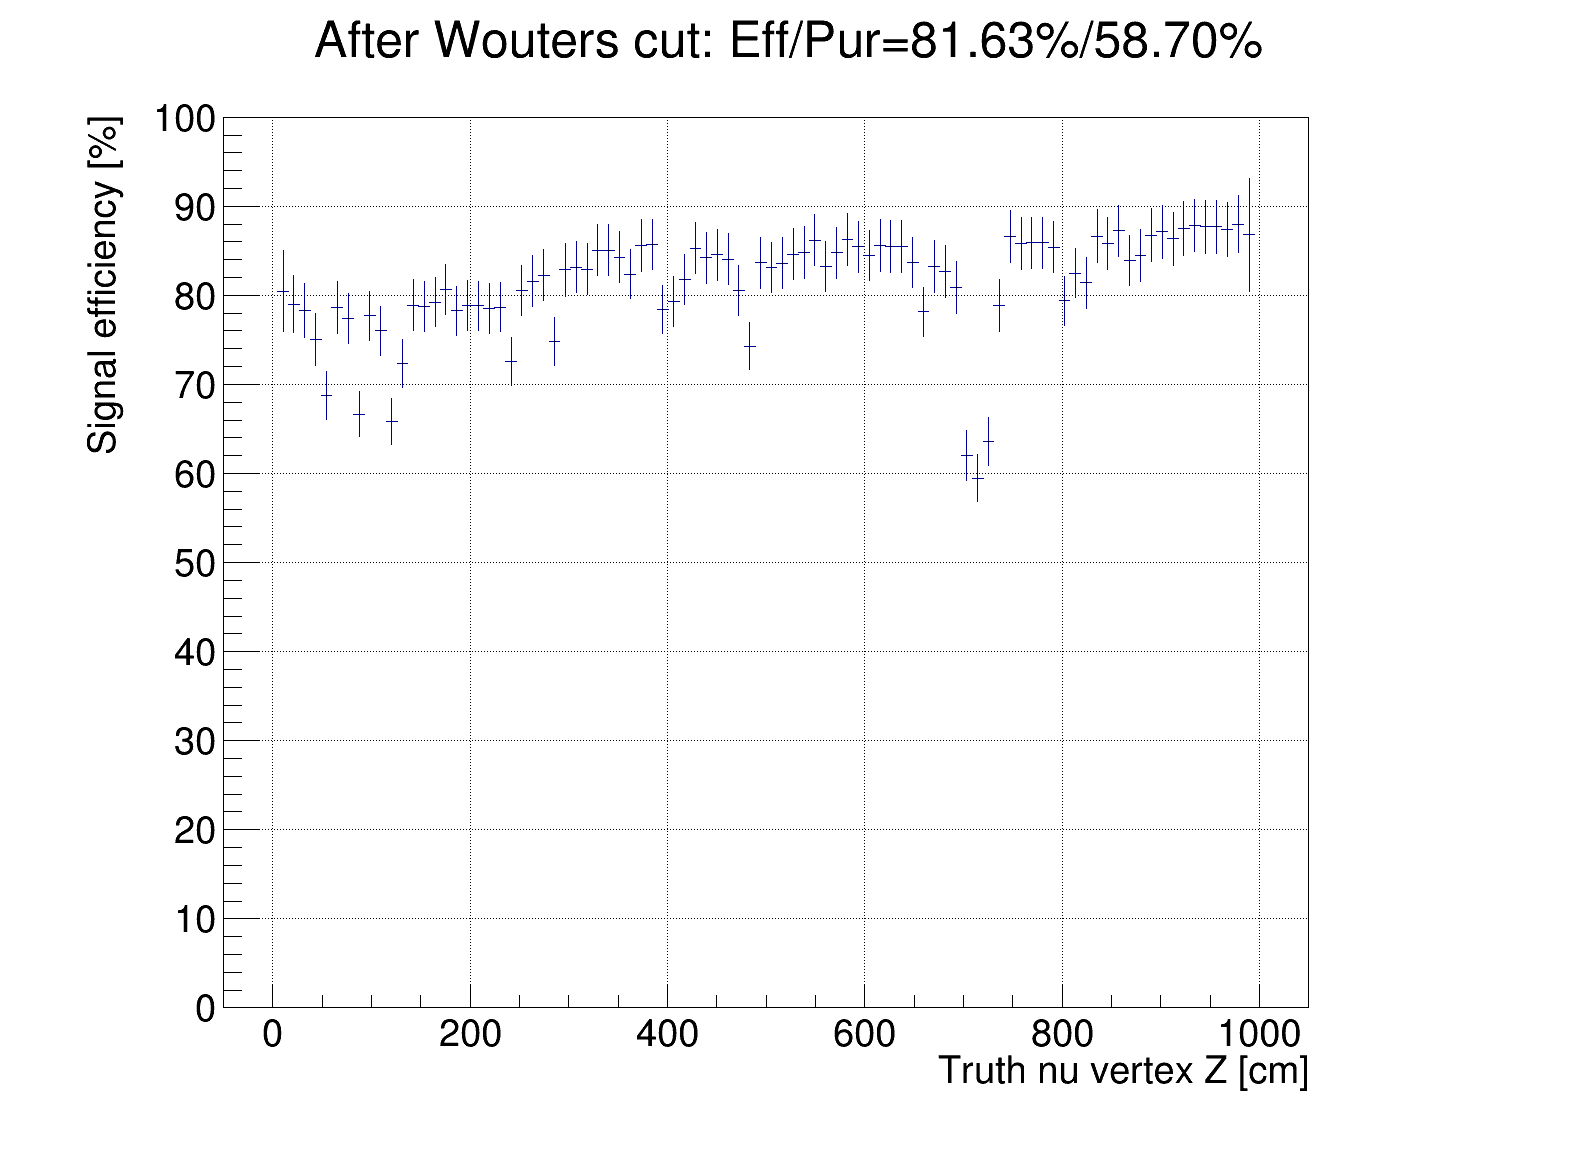

In [17]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25)'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)


name = '_Wouter'
title = 'After Wouters cut:'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)
h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth enutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)
h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth neutrino cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)
h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco neutrino phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



Efficiency:	83.11%
Purity:		62.65%
Efficiency 2:	65.53%
Purity 2:		31.39%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_energy_Wouter_forBackward_reco.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_energy_Wouter_forBackward_reco.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta2 

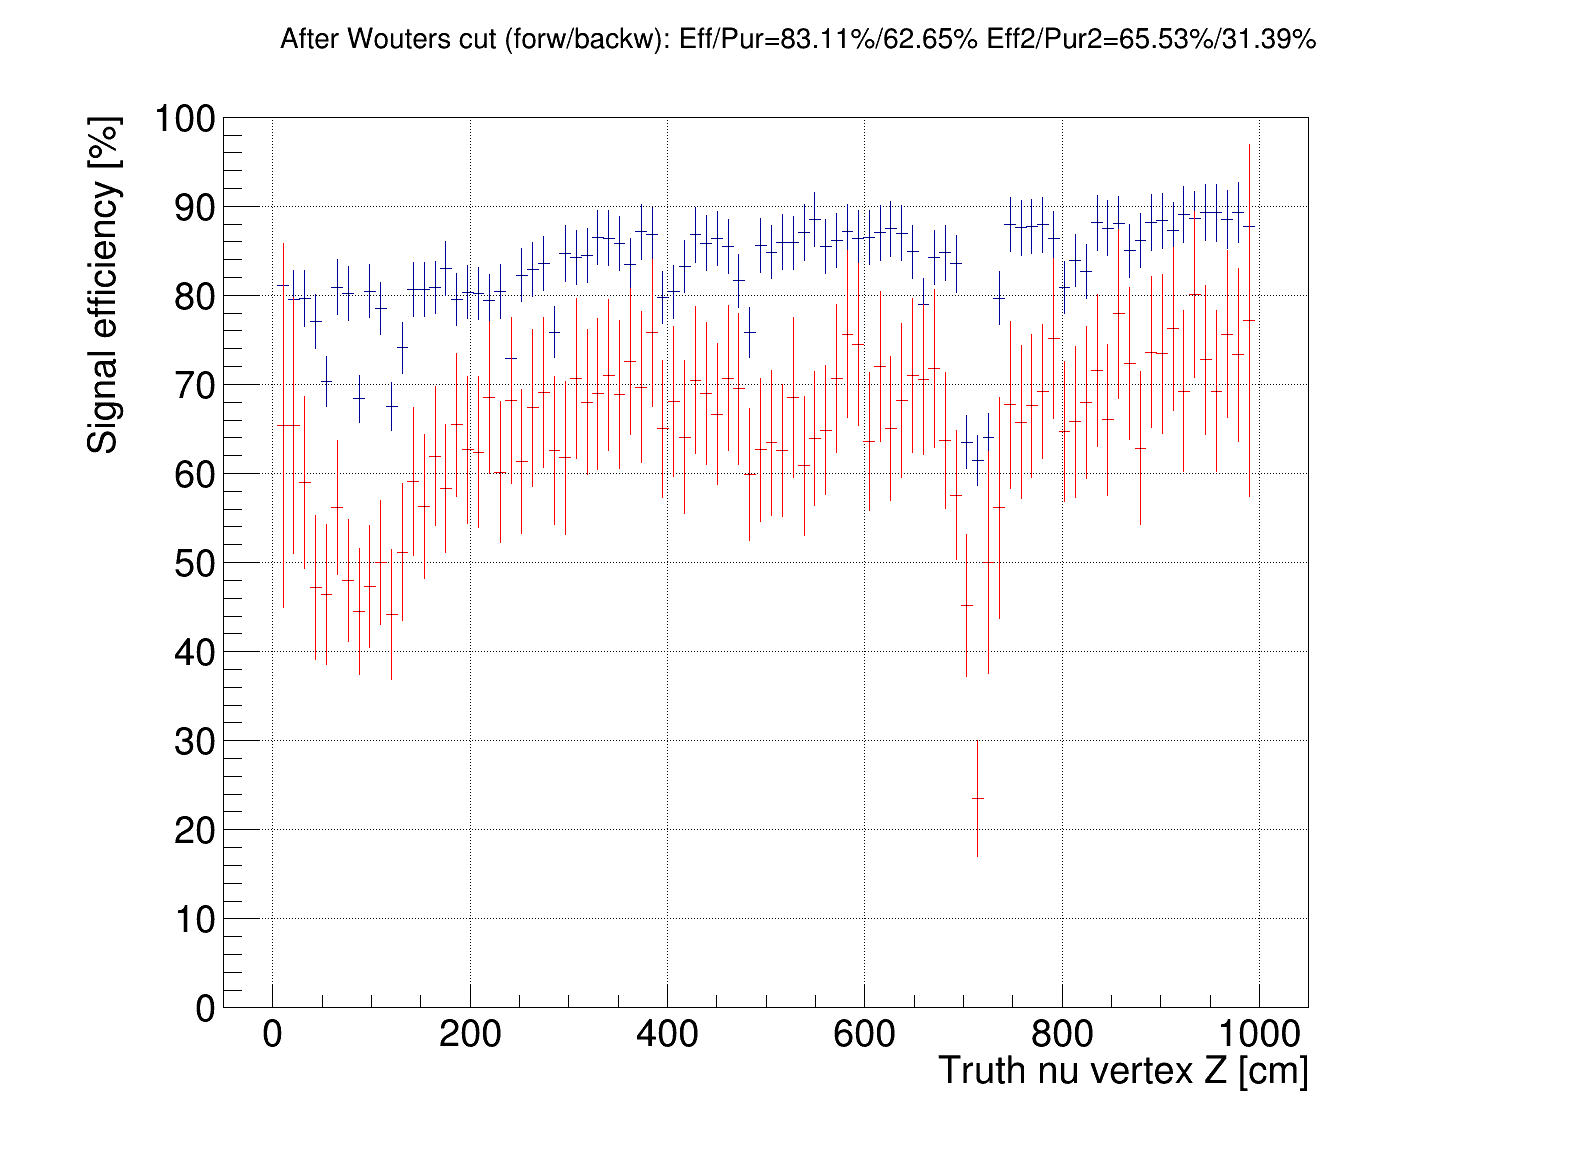

In [30]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && cos(TrackTheta)>0"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)>0"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)>0'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && cos(TrackTheta)<0"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)<0"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && cos(TrackTheta)<0'

efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_forBackward_reco'
title = 'After Wouters cut (forw/backw):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



In [26]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && !track_end_uncontained"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && !track_end_uncontained"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && !track_end_uncontained'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && track_end_uncontained"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && track_end_uncontained"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && track_end_uncontained'

efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_contained'
title = 'After Wouters cut (track_end_uncontained/!):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



Efficiency:	80.95%
Purity:		58.92%
Efficiency 2:	84.34%
Purity 2:		57.84%


AttributeError: 'PyROOT_NoneType' object has no attribute 'Draw'

Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).


Efficiency:	71.05%
Purity:		39.55%
Efficiency 2:	84.13%
Purity 2:		65.00%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//png/h_eff_energy_Wouter_NuTracks.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V_10y//root/h_eff_energy_Wouter_NuTracks.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta2 (Potential memor

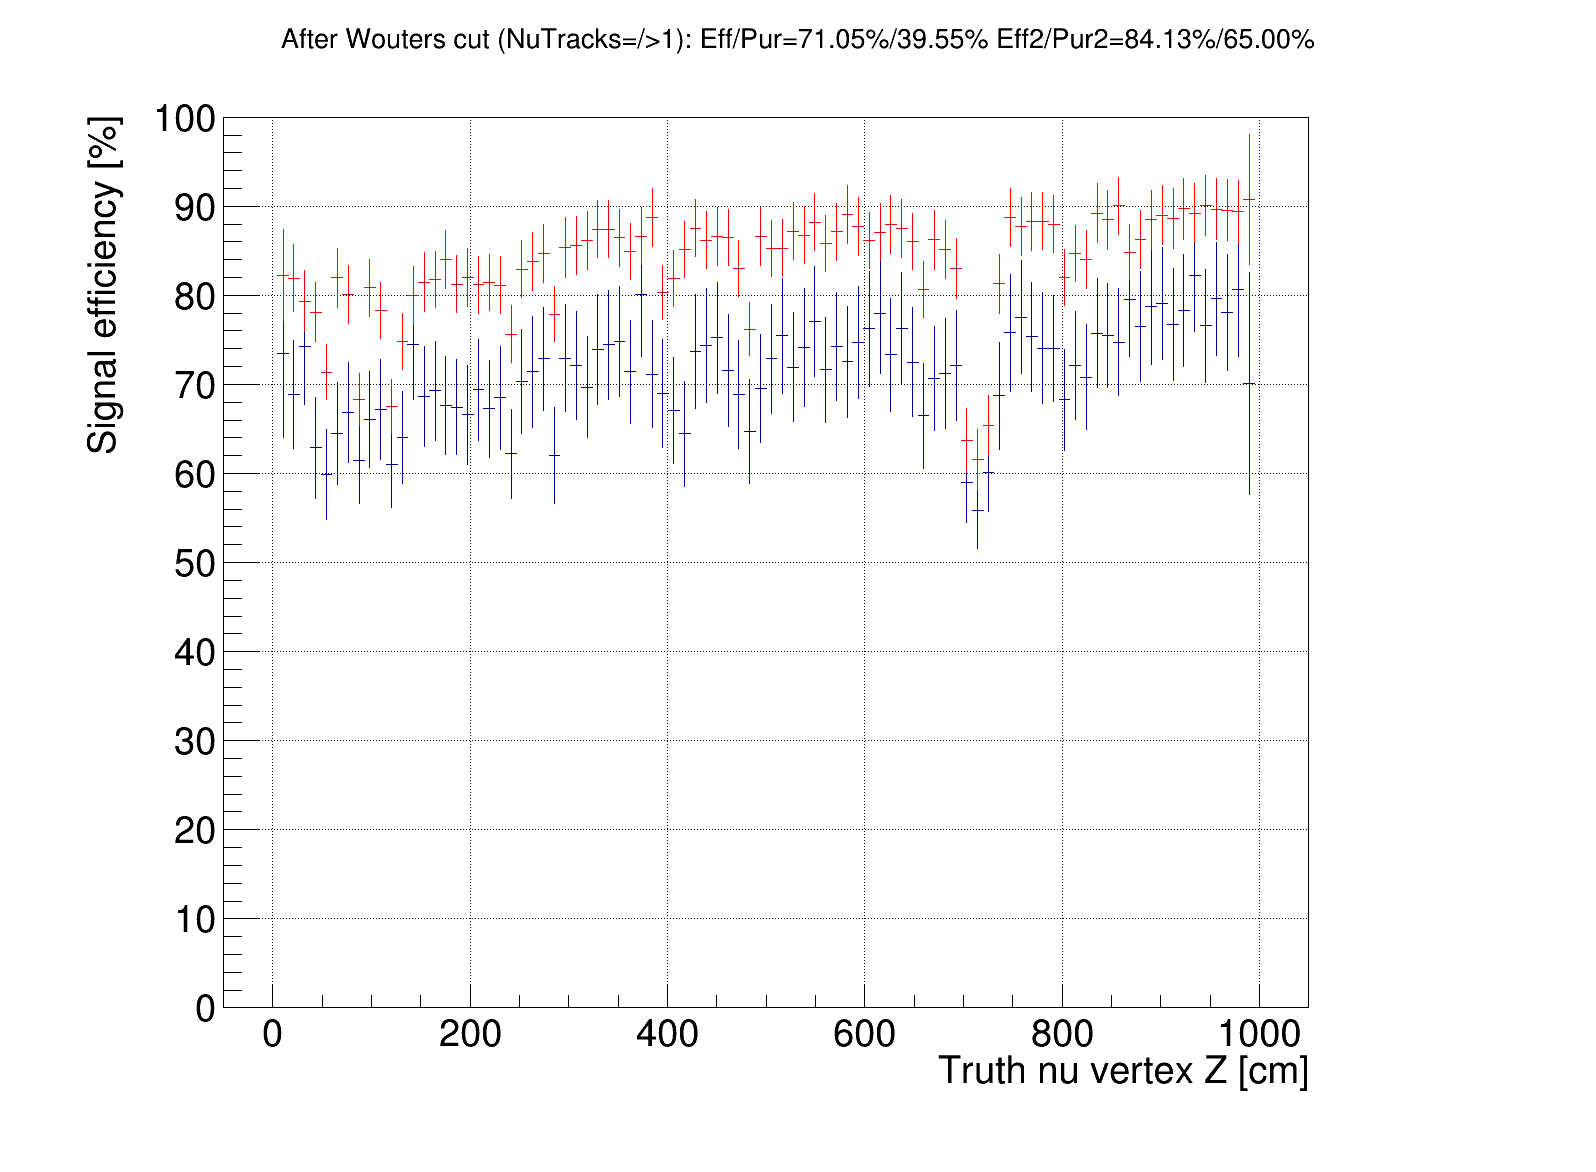

In [31]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && NuTracks==1"
zahler_cut = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks==1"
cut = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks==1'

#efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
#purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)

nenner_cut2 = "numu_signal && muon && NuTracks>1"
zahler_cut2 = "numu_signal && fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks>1"
cut2 = 'fidVol && muon && TrackScore>0.8 && TrackPID_chimuon<60 && TrackPID_chiproton>40 && (TrackPID_chiproton/TrackPID_chimuon)>2 && VtxDistance<5 && NuScore>0.06 && (FlashScore<10 || NuScore>0.25) && NuTracks>1'

#efficiency2 = overlay.GetEntries(zahler_cut2)*100.0/overlay.GetEntries(nenner_cut2)
#purity2 = overlay.GetEntries(cut2+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut2)

print 'Efficiency 2:\t{0:0.2f}%'.format(efficiency2)
print 'Purity 2:\t\t{0:0.2f}%'.format(  purity2)


name = '_Wouter_NuTracks'
title = 'After Wouters cut (NuTracks=/>1):'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)+' Eff2/Pur2={0:0.2f}%'.format( efficiency2)+'/{0:0.2f}%'.format(purity2)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy2',zahler_cut2)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner_cut2)
h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
h_init_eff_energy2.Scale(100)
h_init_eff_energy2.SetLineColor(2)

h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
h_init_eff_energy2.Draw("same")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)

h_init_eff_theta2 = ROOT.TH1F("h_init_eff_theta2",title,xbin,xstart,xend)
h_init_eff_theta_12 = ROOT.TH1F("h_init_eff_theta_12",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta2',zahler_cut2)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_12',nenner_cut2)
h_init_eff_theta_12.Sumw2()
h_init_eff_theta2.Divide(h_init_eff_theta_12)
h_init_eff_theta2.Scale(100)
h_init_eff_theta2.SetLineColor(2)

h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth lepton cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
h_init_eff_theta2.Draw("same E")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)

h_init_eff_phi2 = ROOT.TH1F("h_init_eff_phi2",title,xbin,xstart,xend)
h_init_eff_phi_12 = ROOT.TH1F("h_init_eff_phi_12",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi2',zahler_cut2)
overlay.Draw('TrackPhi>>h_init_eff_phi_12',nenner_cut2)
h_init_eff_phi_12.Sumw2()
h_init_eff_phi2.Divide(h_init_eff_phi_12)
h_init_eff_phi2.Scale(100)
h_init_eff_phi2.SetLineColor(2)

h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco lepton phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
h_init_eff_phi2.Draw("same e")

c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vx>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vy>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)

h_init_eff_V2 = ROOT.TH1F("h_init_eff_V2",title,xbin,xstart,xend)
h_init_eff_V_12 = ROOT.TH1F("h_init_eff_V_12",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V2',zahler_cut2)
overlay.Draw('MCNu_Vz>>h_init_eff_V_12',nenner_cut2)
h_init_eff_V_12.Sumw2()
h_init_eff_V2.Divide(h_init_eff_V_12)
h_init_eff_V2.Scale(100)
h_init_eff_V2.SetLineColor(2)

h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
h_init_eff_V2.Draw("same e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")

